In [1]:
import pickle
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import glob
import torch

from src.model_fitting_funcs import r2_multi, corr_multi, get_lagged_X

In [2]:
SUBJECT = "A"
FEATURES = ["melspectrum", "phoneme", "semantic_c20_layer7"]
TEST_SESSIONS = ["Moth2", "Moth3", "Moth4", "Moth5"]
DATASET_DIR = "/data/story_dataset"  # change to your dataset path
VERSION = "sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected"
DS_FREQ = 50
LOC_MEG_TEMPLATE = f"{DATASET_DIR}/moth_meg/{{}}/{VERSION}/{SUBJECT}/aligned_ds{DS_FREQ}/"
train_slug = "t12345_nonrepeat"
SAVEFIG = False

In [3]:
test_story_list = dict(
    Moth1=["alternateithicatom1", "alternateithicatom2"],
    Moth2=["undertheinfluence1", "undertheinfluence2"],
    Moth3=["stagefright1", "stagefright2"],
    Moth4=["buck1", "buck2"],
    Moth5=["swimmingwithastronauts1", "swimmingwithastronauts2"],
)
test_stories = [story for session in TEST_SESSIONS for story in test_story_list[session]]
test_sessions_num = [s.lstrip("Moth") for s in TEST_SESSIONS]

In [4]:
# story to session and block mapping
with open("data/story_sess_block.pkl", "rb") as f:
    story_sess_block = pickle.load(f)
print(story_sess_block)

{'stimuli_auditory_localizer': ('Moth1', '01'), 'alternateithicatom1': ('Moth1', '02'), 'souls': ('Moth1', '03'), 'wheretheressmoke1': ('Moth1', '04'), 'avatar': ('Moth1', '05'), 'legacy': ('Moth1', '06'), 'odetostepfather': ('Moth1', '07'), 'alternateithicatom2': ('Moth1', '08'), 'undertheinfluence1': ('Moth2', '01'), 'howtodraw': ('Moth2', '02'), 'myfirstdaywiththeyankees': ('Moth2', '03'), 'wheretheressmoke2': ('Moth2', '04'), 'naked': ('Moth2', '05'), 'life': ('Moth2', '06'), 'undertheinfluence2': ('Moth2', '07'), 'stagefright1': ('Moth3', '01'), 'tildeath': ('Moth3', '02'), 'wheretheressmoke3': ('Moth3', '03'), 'fromboyhoodtofatherhood': ('Moth3', '04'), 'sloth': ('Moth3', '05'), 'exorcism': ('Moth3', '06'), 'stagefright2': ('Moth3', '07'), 'buck1': ('Moth4', '01'), 'adollshouse': ('Moth4', '02'), 'wheretheressmoke4': ('Moth4', '03'), 'inamoment': ('Moth4', '04'), 'theclosetthatateeverything': ('Moth4', '05'), 'adventuresinsayingyes': ('Moth4', '06'), 'haveyoumethimyet': ('Moth4',

## Load Training Results

Stacked ridge regression is done elsewhere.

In [5]:
with open(f"data/{SUBJECT}_{train_slug}.pkl", "rb") as f:
    weights = pickle.load(f)
    S = pickle.load(f)
    max_L = pickle.load(f)

In [6]:
len(weights), S.shape, max_L

(31, (306, 31), 30)

## Load Design Matrices

In [7]:
story_design_matrices_dict = {}
for FEATURE in FEATURES:
    # load design matrices
    with open(f"{DATASET_DIR}/design_matrix/ds{DS_FREQ}/{FEATURE}/{SUBJECT}_stretched_indrate.pkl", "rb") as f:
        story_design_matrices = pickle.load(f)
    story_design_matrices_dict[FEATURE] = story_design_matrices

In [8]:
# get the standard scaler from the training matrix
train_story_list = dict(
    Moth1=["souls", "avatar", "legacy", "odetostepfather"],
    Moth2=["howtodraw", "myfirstdaywiththeyankees", "naked", "life"],
    Moth3=["tildeath", "fromboyhoodtofatherhood", "sloth", "exorcism"],
    Moth4=["adollshouse", "inamoment", "theclosetthatateeverything", "adventuresinsayingyes", "haveyoumethimyet"],
    Moth5=["thatthingonmyarm", "eyespy", "itsabox", "hangtime"],
)
TRAIN_SESSIONS = ["Moth1", "Moth2", "Moth3", "Moth4", "Moth5"]
train_stories = [story for session in TRAIN_SESSIONS for story in train_story_list[session]]

train_design_matrices = []
for this_story in train_stories:
    print(this_story)

    # get the design matrix for each feature
    this_story_design_matrices = []
    for FEATURE in FEATURES:
        design_matrix = story_design_matrices_dict[FEATURE][this_story]
        this_story_design_matrices.append(design_matrix)

    # pad the design matrices
    max_len = max([dm.shape[0] for dm in this_story_design_matrices])
    this_story_design_matrices_padded = []
    for dm in this_story_design_matrices:
        dm_padded = np.pad(dm, ((0, max_len - dm.shape[0]), (0, 0)))
        this_story_design_matrices_padded.append(dm_padded)

    # concatenate
    this_story_design_matrix = np.concatenate(this_story_design_matrices_padded, axis=1)
    print(this_story_design_matrix.shape)
    train_design_matrices.append(this_story_design_matrix)

# concatenate all training design matrices
train_design_matrix = np.concatenate(train_design_matrices, axis=0)
del train_design_matrices

# normalization
scaler = StandardScaler()
scaler.fit(train_design_matrix)
del train_design_matrix

souls
(36551, 852)
avatar
(37751, 852)
legacy
(41051, 852)
odetostepfather
(41451, 852)
howtodraw
(36451, 852)
myfirstdaywiththeyankees
(36901, 852)
naked
(43301, 852)
life


(44051, 852)
tildeath
(33401, 852)
fromboyhoodtofatherhood
(35901, 852)
sloth
(44801, 852)
exorcism
(47801, 852)
adollshouse
(25201, 852)
inamoment
(21551, 852)
theclosetthatateeverything
(32501, 852)
adventuresinsayingyes
(40201, 852)
haveyoumethimyet
(50701, 852)
thatthingonmyarm
(44501, 852)
eyespy
(39001, 852)
itsabox
(36601, 852)
hangtime
(33451, 852)


In [9]:
# get testing design matrix
test_design_matrices = []

for story in test_stories:
    print(story)

    # skip if the story is repeated
    if int(story[-1]) > 1:
        continue

    # get the design matrix for each feature
    story_design_matrices = []
    for FEATURE in FEATURES:
        design_matrix = story_design_matrices_dict[FEATURE][story]
        story_design_matrices.append(design_matrix)

    # pad the design matrices
    max_len = max([dm.shape[0] for dm in story_design_matrices])
    story_design_matrices_padded = []
    for dm in story_design_matrices:
        dm_padded = np.pad(dm, ((0, max_len - dm.shape[0]), (0, 0)))
        story_design_matrices_padded.append(dm_padded)

    # concatenate
    story_design_matrix = np.concatenate(story_design_matrices_padded, axis=1)
    print(story_design_matrix.shape)

    # normalize
    story_design_matrix = scaler.transform(story_design_matrix)
    story_design_matrix = np.clip(story_design_matrix, -5, 5)
    story_design_matrix = story_design_matrix.astype(np.float32)
    test_design_matrices.append(story_design_matrix)

# pick the first design matrix for testing if averge, else concatenate all
test_samples = [dm.shape[0] for dm in test_design_matrices]

undertheinfluence1
(31451, 852)
undertheinfluence2
stagefright1
(30366, 852)


stagefright2
buck1
(34301, 852)
buck2
swimmingwithastronauts1
(39601, 852)
swimmingwithastronauts2


## Load True MEG Data

In [10]:
# get testing MEG data
test_meg_datas = []
for story in test_stories:

    # load the MEG data
    session, block = story_sess_block[story]
    raw_dir = LOC_MEG_TEMPLATE.format(session)
    raw_file = glob.glob(raw_dir + f"{SUBJECT}_{session}_{block}*.fif")[0]
    raw = mne.io.read_raw_fif(raw_file).pick(["meg"]).load_data()
    meg_data = raw.get_data().T

    # zscore the data
    meg_data = zscore(meg_data, axis=0)
    test_meg_datas.append(meg_data.astype(np.float32))

Opening raw data file /data/story_dataset/moth_meg/Moth2/sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected/A/aligned_ds50/A_Moth2_01_sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected_aligned_ds50_raw.fif...
    Range : 6755 ... 38269 =    135.100 ...   765.380 secs
Ready.
Reading 0 ... 31514  =      0.000 ...   630.280 secs...
Opening raw data file /data/story_dataset/moth_meg/Moth2/sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected/A/aligned_ds50/A_Moth2_07_sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected_aligned_ds50_raw.fif...
    Range : 898 ... 32412 =     17.960 ...   648.240 secs
Ready.
Reading 0 ... 31514  =      0.000 ...   630.280 secs...
Opening raw data file /data/story_dataset/moth_meg/Moth3/sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected/A/aligned_ds50/A_Moth3_01_sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected_aligned_ds50_raw.fif...
    Range : 3639 ... 34103 =     72.780 ...   682.060 secs
Ready

In [11]:
# average repeated testing MEG data
test_meg_datas_tmp = []
for i, data in enumerate(test_meg_datas):
    if i % 2 == 0:
        data1 = data
    else:
        assert min(data.shape[0], data1.shape[0]) > test_samples[i // 2]
        data1 = data1[: test_samples[i // 2], :]
        data = data[: test_samples[i // 2], :]
        test_meg_datas_tmp.append(np.mean(np.stack([data, data1]), axis=0))
test_meg_datas = test_meg_datas_tmp
del test_meg_datas_tmp, data, data1

## Ridge Predict

In [12]:
def get_stacked_preds(test_design_matrix, weights, S, max_L):
    """Assume test_design_matrix is already padded."""
    preds = []
    for l in range(max_L):
        test_design_matrix_lagged = get_lagged_X(torch.from_numpy(test_design_matrix), l, max_L)
        pred_l = (test_design_matrix_lagged @ torch.from_numpy(weights[l])).numpy()
        pred_l *= S[:, l]
        preds.append(pred_l)
    stacked_preds = np.sum(preds, axis=0)
    return stacked_preds

In [13]:
# average repeated testing MEG data
stacked_r2_chs_allcomb, stacked_corr_chs_allcomb = [], []

for test_design_matrix, test_meg_data in zip(test_design_matrices, test_meg_datas):

    # get the stacked predictions
    test_design_matrix = np.pad(test_design_matrix, ((0, max_L), (0, 0)))
    stacked_preds = get_stacked_preds(test_design_matrix, weights, S, max_L)

    # calculate r2
    stacked_r2_chs_allcomb.append(r2_multi(test_meg_data, stacked_preds[:-max_L]))

    # calculate corr
    stacked_corr_chs_allcomb.append(corr_multi(test_meg_data, stacked_preds[:-max_L]))

stacked_r2_chs_combavg = np.mean(stacked_r2_chs_allcomb, axis=0)
stacked_corr_chs_combavg = np.mean(stacked_corr_chs_allcomb, axis=0)
stacked_r2_chs_combavg.shape

(306,)

## Plot

In [14]:
# get mag and grad indices and infos
mag_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["mag"]
grad_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["grad"]
mag_info = raw.copy().pick("mag").info
grad_info = raw.copy().pick("grad").info

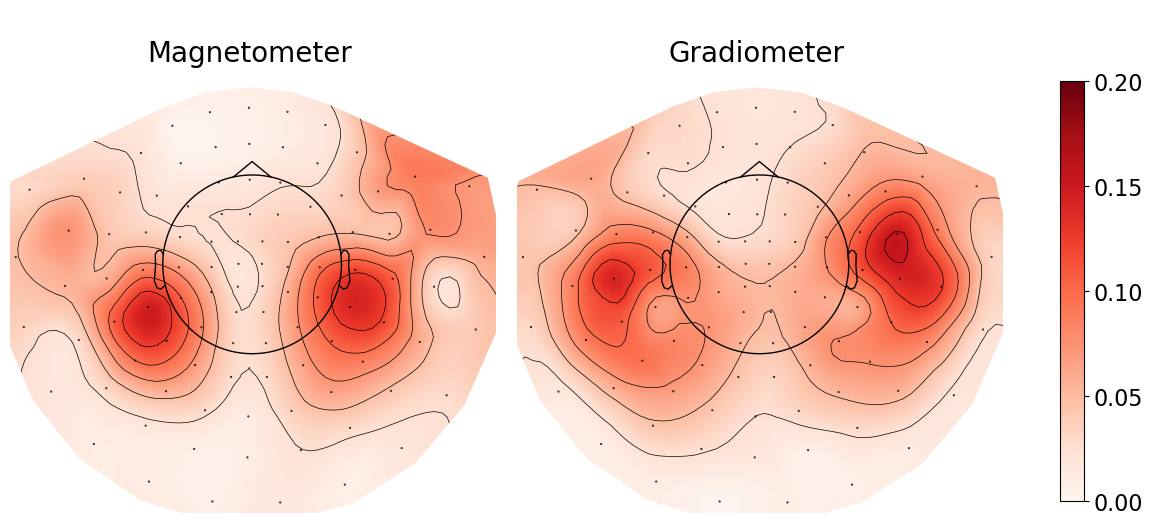

In [15]:
# plot correlation
mag_corr_chs = stacked_corr_chs_combavg[mag_idx]
grad_corr_chs = stacked_corr_chs_combavg[grad_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
h = mne.viz.plot_topomap(mag_corr_chs, mag_info, vlim=(0, 0.2), show=False, size=4, axes=axes[0], cmap="Reds")
h2 = mne.viz.plot_topomap(grad_corr_chs, grad_info, vlim=(0, 0.2), show=False, size=4, axes=axes[1], cmap="Reds")
for ax in axes:
    box = ax.get_position()
    ax.set_position([box.x0 - 0.08, box.y0, box.width * 1.15, box.height * 1.15])

# color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(h[0], cax=cbar_ax)
cbar_ax.set_yticks(np.arange(0, 0.21, 0.05))
cbar_ax.tick_params(labelsize=16)

# title
x0, y0 = 0, 0.21
axes[0].text(x0, y0, "Magnetometer", fontsize=20, ha="center", va="bottom", color="black")
axes[1].text(x0, y0, "Gradiometer", fontsize=20, ha="center", va="bottom", color="black")

if SAVEFIG:
    plt.savefig(f"figures/{SUBJECT}/ridge_meg_corr.png", dpi=300)
plt.show()